In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [6]:
def g_left_of_main(car, road_rules):
    return road_rules["x_min"] - car.state[0]

def g_right_of_main(car, road_rules):
    return car.state[0] - road_rules["x_max"]

def g_outside_rightband(car, road_rules):
    return max(
        car.state[1] - road_rules["y_max"],
        road_rules["y_min"] - car.state[1]
    )

In [10]:
"""
BSD 3-Clause License

Copyright (c) 2019, HJ Reachability Group
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

Author(s): David Fridovich-Keil ( dfk@eecs.berkeley.edu )
"""
################################################################################
#
# Base class for all continuous-time dynamical systems. Supports numerical
# integration and linearization.
#
################################################################################

import torch
import numpy as np
from scipy.linalg import expm

class DynamicalSystem(object):
    """ Base class for all dynamical systems. """

    def __init__(self, x_dim, u_dim, T=0.1):
        """
        Initialize with number of state/control dimensions.

        :param x_dim: number of state dimensions
        :type x_dim: uint
        :param u_dim: number of control dimensions
        :type u_dim: uint
        :param T: time interval
        :type T: float
        """
        self._x_dim = x_dim
        self._u_dim = u_dim
        self._T = T

    def __call__(self, x, u):
        """
        Compute the time derivative of state for a particular state/control.
        NOTE: `x` and `u` should be 2D (i.e. column vectors).

        :param x: current state
        :type x: torch.Tensor or np.array
        :param u: current control input
        :type u: torch.Tensor or np.array
        :return: current time derivative of state
        :rtype: torch.Tensor or np.array
        """
        raise NotImplementedError("__call__() has not been implemented.")

    def integrate(self, x0, u, dt=None):
        """
        Integrate initial state x0 (applying constant control u)
        over a time interval of length T, using a time discretization
        of dt.

        :param x0: initial state
        :type x0: np.array
        :param u: control input
        :type u: np.array
        :param dt: time discretization
        :type dt: float
        :return: state after time T
        :rtype: np.array
        """
        if dt is None:
            dt = 0.1 * self._T

        t = 0.0
        x = x0.copy()
        while t < self._T - 1e-8:
            # Make sure we don't step past T.
            step = min(dt, self._T - t)

            # Use Runge-Kutta order 4 integration. For details please refer to
            # https://en.wikipedia.org/wiki/Runge-Kutta_methods.
            k1 = step * self.__call__(x, u)
            k2 = step * self.__call__(x + 0.5 * k1, u)
            k3 = step * self.__call__(x + 0.5 * k2, u)
            k4 = step * self.__call__(x + k3, u)

            x += (k1 + 2.0 * k2 + 2.0 * k3 + k4) / 6.0
            t += step

        return x

    def linearize(self, x0, u0):
        """
        Compute the Jacobian linearization of the dynamics for a particular
        state `x0` and control `u0`. Outputs `A` and `B` matrices of a linear
        system:
                   ```\dot x - f(x0, u0) = A (x - x0) + B (u - u0)```

        :param x: state
        :type x: np.array
        :param u: control input
        :type u: np.array
        :return: (A, B) matrices of linearized system
        :rtype: np.array, np.array
        """
        x_torch = torch.from_numpy(x0).requires_grad_(True)
        u_torch = torch.from_numpy(u0).requires_grad_(True)

        x_dot = self.__call__(x_torch, u_torch)

        x_gradient_list = []
        u_gradient_list = []
        for ii in range(self._x_dim):
            x_gradient_list.append(torch.autograd.grad(
                x_dot[ii, 0], x_torch, retain_graph=True)[0])
            u_gradient_list.append(torch.autograd.grad(
                x_dot[ii, 0], u_torch, retain_graph=True)[0])

        A = torch.cat(x_gradient_list, dim=1).detach().numpy().copy().T
        B = torch.cat(u_gradient_list, dim=1).detach().numpy().copy().T
        return A, B

    def linearize_discrete(self, x0, u0):
        """
        Compute the Jacobian linearization of the dynamics for a particular
        state `x0` and control `u0`. Outputs `A` and `B` matrices of a
        discrete-time linear system:
              ``` x(k + 1) - x0 = A (x(k) - x0) + B (u(k) - u0) ```

        :param x0: state
        :type x0: np.array
        :param u0: control input
        :type u0: np.array
        :return: (A, B) matrices of the disctete-time linearized system
        :rtype: np.array, np.array
        """
        A_cont, B_cont = self.linearize(x0, u0)

        eAT = expm(A_cont * self._T)
        Ainv = np.linalg.pinv(A_cont)

        # See https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models
        # for derivation of discrete-time from continuous time linear system.
        A_disc = eAT
        B_disc = Ainv @ (eAT - np.eye(self._x_dim)) @ B_cont
        
        #print("A_disc in dynamical system is: ", A_disc)
        #print("B_disc in dynamical system is: ", B_disc)

        return A_disc, B_disc


In [7]:
# s: state of system
# x: x coordinate of car
# y: y coordinate of car
# theta: heading angle of car wrt world coordinate
# phi: steering angle
# v: velocity
# system has 2 cars
# s = [x1, y1, theta1, phi1, v1, x2, y2, theta2, phi2, v2]

In [11]:
################################################################################
#
# 5D car model. Dynamics are as follows, adapted from
# https://ac.els-cdn.com/S2405896316301215/1-s2.0-S2405896316301215-main.pdf?_tid=ad143a13-6571-4733-a984-1b5a41960e78&acdnat=1552430727_12aedd0da2ca11eb07eef49d27b5ab12
#                          \dot x     = v cos theta
#                          \dot y     = v sin theta
#                          \dot theta = v * tan(phi) / l
#                          \dot phi   = u1
#                          \dot v     = u2
#
################################################################################

import torch
import numpy as np

class Car5Dv2(DynamicalSystem):
    """ 5D car model. """

    def __init__(self, T=0.1, **kwargs):
        self._l = kwargs["wheelbase"]
        self.length = kwargs["length"]
        self.width = kwargs["width"]
        self.R = math.sqrt((0.5 * (self.length - self._l)) ** 2 + (0.5 * self.width) ** 2) 
        
        self.state = np.zeros(5)
        
        super(Car5Dv2, self).__init__(5, 2, T)
        
    def get_poc(self):
        rear = np.array([self.state[0], self.state[1]]) # rear
        front = rear + self._l * np.array([math.cos(self.state[2]), math.sin(self.state[2])]) # front
        return rear, front

    def __call__(self, x, u):
        """
        Compute the time derivative of state for a particular state/control.
        NOTE: `x` and `u` should be 2D (i.e. column vectors).

        :param x: current state
        :type x: torch.Tensor or np.array
        :param u: current control input
        :type u: torch.Tensor or np.array
        :return: current time derivative of state
        :rtype: torch.Tensor or np.array
        """
        if isinstance(x, np.ndarray):
            assert isinstance(u, np.ndarray)
            x_dot = np.zeros((self._x_dim, 1))
            cos = np.cos
            sin = np.sin
            tan = np.tan
        else:
            assert isinstance(u, torch.Tensor)
            x_dot = torch.zeros((self._x_dim, 1))
            cos = torch.cos
            sin = torch.sin
            tan = torch.tan

        x_dot[0, 0] = x[4, 0] * cos(x[2, 0])
        x_dot[1, 0] = x[4, 0] * sin(x[2, 0])
        x_dot[2, 0] = x[4, 0] * tan(x[3, 0]) / self._l
        x_dot[3, 0] = u[0, 0]
        x_dot[4, 0] = u[1, 0]
        
        self.state = x
        
        return x_dot


In [12]:
# car params
# Delorean DMC
# https://en.wikipedia.org/wiki/DMC_DeLorean

car_params = {
    "wheelbase": 2.413, 
    "length": 4.267,
    "width": 1.988
}

car1 = Car5Dv2(T = 0.1, **car_params)
car2 = Car5Dv2(T = 0.1, **car_params)

def g_coll_ff(car1, car2):
    car1_rear, car1_front = car1.get_poc()
    car2_rear, car2_front = car2.get_poc()
    return 4 * car1.R**2 - (car1_front[0] - car2_front[0]) ** 2 - (car1_front[1] - car2_front[1]) ** 2

def g_coll_fr(car1, car2):
    car1_rear, car1_front = car1.get_poc()
    car2_rear, car2_front = car2.get_poc()
    return 4 * car1.R**2 - (car1_front[0] - car2_rear[0]) ** 2 - (car1_front[1] - car2_rear[1]) ** 2

def g_coll_rf(car1, car2):
    car1_rear, car1_front = car1.get_poc()
    car2_rear, car2_front = car2.get_poc()
    return 4 * car1.R**2 - (car1_rear[0] - car2_front[0]) ** 2 - (car1_rear[1] - car2_front[1]) ** 2

def g_coll_rr(car1, car2):
    car1_rear, car1_front = car1.get_poc()
    car2_rear, car2_front = car2.get_poc()
    return 4 * car1.R**2 - (car1_rear[0] - car2_rear[0]) ** 2 - (car1_rear[1] - car2_rear[1]) ** 2

In [13]:
# road rules for T-intersection
#----------------
#|  |        |
#|           |
#|  |        |
#|           |
#|  |        |_______________ y_max
#|
#|  |
#|
#|  |        ._______________ y_min
#|           |
#|  |        |
#|           |
#x_min    x_max

road_rules = {
    "x_min": 2,
    "x_max": 9,
    "y_max": 17,
    "y_min": 10,
    "width": 3.5,
}

def circle_intersection(car, x_circle, y_circle, r_circle):
    return r_circle**2 - (car.state[0] - x_circle) ** 2 - (car.state[1] - y_circle) ** 2

def g_road_rules(car, road_rules, left_lane = True, right_lane = True, up_lane = False, down_lane = True, left_turn = False):
    """
        Only use for T intersection that both cars can only either go straight or merge to the left of the map.
            * Cars that are on the right lane can turn right or go straight up
            * Cars that are on the left lane can turn left or go straight down
        Use the flags to bound the safety area:
            left_turn (bool): allow left turn, with safety arc at the corner
            left_lane (bool): allow running on left lane
            right_lane (bool): allow running on the right lane
            up_lane (bool): allow running on the up lane
            down_lane (bool): allow running on the down lane
    """
    import copy
    new_road_rules = copy.deepcopy(road_rules)
    if down_lane and not up_lane:
        new_road_rules["y_max"] = road_rules["y_max"] - road_rules["width"]
    elif up_lane and not down_lane:
        new_road_rules["y_min"] = road_rules["y_min"] + road_rules["width"]
    
    if left_lane and not right_lane:
        # Can either go straight down or turn left
        new_road_rules["x_max"] = road_rules["x_max"] - road_rules["width"]
    elif right_lane and not left_lane:
        # Can either go straight up or turn right
        new_road_rules["x_min"] = road_rules["x_min"] + road_rules["width"]
        
    if not left_turn:
        return max(
            g_left_of_main(car, new_road_rules), 
            min(
                g_right_of_main(car, new_road_rules), 
                g_outside_rightband(car, new_road_rules)
            )
        )
    else:
        x_circle = road_rules["x_max"]
        y_circle = road_rules["y_max"]
        r_circle = road_rules["width"]
        return max(
            g_road_rules(car, road_rules, left_lane = True, right_lane = False, up_lane = True, down_lane = True, left_turn = False),
            g_road_rules(car, road_rules, left_lane = True, right_lane = True, down_lane = True, up_lane = False, left_turn = False),
            circle_intersection(car, x_circle, y_circle, r_circle)
        )

def g_maneuver(car):
    pass

def g_collision(car1, car2):
    return max(
        g_coll_ff(car1, car2),
        g_coll_fr(car1, car2),
        g_coll_rf(car1, car2),
        g_coll_rr(car1, car2)
    )

# def g(car1, car2, road_rules):
#     return max(g_road_rules(car1, road_rules), g_maneuver(car1), g_collision(car1, car2))

In [14]:
# def circle_intersection(car, x_circle, y_circle, r_circle):
#     return r_circle**2 - (car.state[0] - x_circle) ** 2 - (car.state[1] - y_circle) ** 2

# def g_road_rules_left_turn(car, road_rules):
#     road_rules_offset_1 = {
#         "x_min": 2,
#         "x_max": 2 + 3.5,
#         "y_max": 17,
#         "y_min": 10,
#         "wdith": 3.5,
#         "left_turn": True
#     }
    
#     road_rules_offset_2 = {
#         "x_min": 2,
#         "x_max": 9,
#         "y_max": 10 + 3.5,
#         "y_min": 10,
#         "wdith": 3.5,
#         "left_turn": True
#     }
    
#     x_circle = 9
#     y_circle = 17
#     r_circle = road_rules["width"]
    
#     return max(
#         g_road_rules(car, road_rules_offset_1),
#         g_road_rules(car, road_rules_offset_2),
#         circle_intersection(car, x_circle, y_circle, r_circle)
#     )

In [15]:
def draw_roads(road_rules, x_max, y_max):
    """
        x_max: max value of plot in x axis
        y_max: max value of plot in y axis
    """
    print(road_rules)
    # This function draw t-intersection based on road_rules
    x_center = road_rules["x_min"] + 0.5 * (road_rules["x_max"] - road_rules["x_min"])
    y_center = road_rules["y_min"] + 0.5 * (road_rules["y_max"] - road_rules["y_min"])
    plt.plot([road_rules["x_min"], road_rules["x_min"]], [0, x_max], c='k')
    plt.plot([road_rules["x_max"], road_rules["x_max"]], [0, road_rules["y_min"]], c='k')
    plt.plot([road_rules["x_max"], road_rules["x_max"]], [road_rules["y_max"], x_max], c='k')
    plt.plot([road_rules["x_min"], road_rules["x_min"]], [road_rules["y_min"], road_rules["y_min"]], c='k')
    plt.plot([road_rules["x_max"], y_max], [road_rules["y_min"], road_rules["y_min"]], c='k')
    plt.plot([road_rules["x_min"], road_rules["x_min"]], [road_rules["y_max"], road_rules["y_max"]], c='k')
    plt.plot([road_rules["x_max"], y_max], [road_rules["y_max"], road_rules["y_max"]], c='k')
    plt.plot([x_center, x_center], [0, x_max], "--", c = 'b')
    plt.plot([road_rules["x_max"], y_max], [y_center, y_center], "--", c = 'b')

In [16]:
from matplotlib.transforms import Affine2D

# fig = plt.figure()
# plt.gca().set_aspect('equal')

# rear = np.array([2, 1])
# rotate_deg = 30
# length = 4.2
# width = 1.7
# wheelbase = 3
# a = 0.5 * (length - wheelbase)

# plt.plot(rear[0], rear[1], color='r', marker='o', markersize=10)
# rec = plt.Rectangle(rear+np.array([-a, -0.5*width]), width=length, height=width, color='g', alpha=0.9,
#                         transform=Affine2D().rotate_deg_around(*(rear[0], rear[1]), rotate_deg)+plt.gca().transData)
# plt.gca().add_patch(rec)
# plt.show()

def draw_car(cars):
    for car in cars:
        plt.gca().set_aspect('equal')
        rear, front = car.get_poc()
        rotate_deg = car.state[2]/np.pi * 180
        length = car.length
        width = car.width
        wheelbase = car._l
        a = 0.5 * (length - wheelbase)

        plt.plot(rear[0], rear[1], color='r', marker='o', markersize=10)
        rec = plt.Rectangle(rear-np.array([a, 0.5*width]), width=length, height=width, color = 'g', alpha=0.8,
                                transform=Affine2D().rotate_deg_around(*(rear[0], rear[1]), rotate_deg)+plt.gca().transData)
        plt.gca().add_patch(rec)
        
def safety_contour(road_rules, left_lane = False, right_lane = False, up_lane = False, down_lane = False, left_turn = False):
    x_range = np.arange(0, 20, step = 0.1)
    y_range = np.arange(0, 25, step = 0.1)
    car = Car5Dv2(T = 0.1, **car_params)
    zz = np.array([[0]*200]*250)
    for x in x_range:
        for y in y_range:
            car.state = np.array([x, y, 0, 0, 0])
            zz[int(y*10)][int(x*10)] = g_road_rules(car, road_rules, left_lane = left_lane, right_lane = right_lane, up_lane = up_lane, down_lane = down_lane, left_turn = left_turn)
    # contour = plt.contourf(x_range, y_range, zz, cmap = "YlGn", levels = np.arange(-10, 30))
    # plt.colorbar(contour)

    contour = plt.contourf(x_range, y_range, zz, cmap = "Purples", alpha = 0.3, levels = [-3, -2, -1, 0], extend = "both")
    plt.clabel(contour, inline=True, fontsize=10, colors="k")
    contour.cmap.set_under('white')
    contour.cmap.set_over('navy')

-55.21556880957156
0.0 -1.0
{'x_min': 2, 'x_max': 9, 'y_max': 17, 'y_min': 10, 'width': 3.5}


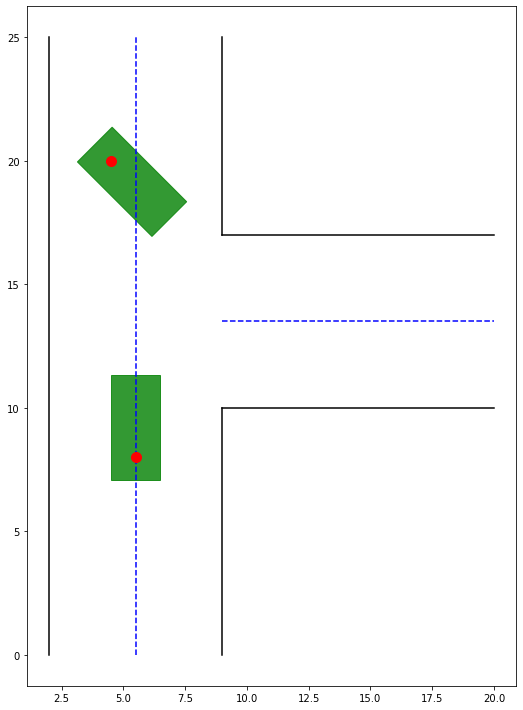

In [20]:
car1.state = np.array([5.5, 8, np.pi/2, 0, 0])
car2.state = np.array([4.5, 20, -np.pi/4, 0, 0])
print(g_collision(car1, car2))
print(
    g_road_rules(car1, road_rules, left_lane = False, right_lane = True, up_lane = False, down_lane = True, left_turn = False),
    g_road_rules(car2, road_rules, left_lane = True, right_lane = False, up_lane = False, down_lane = True, left_turn = True)
)

fig = plt.figure(figsize = (10, 12.5))
# draw the roads
draw_roads(road_rules, 25, 20)
draw_car([car1, car2])
# safety_contour(road_rules, left_lane = False, right_lane = True, up_lane = False, down_lane = True, left_turn = False)
plt.show()